# HMM Example

研究目的：
- 使用HMM进行市场状态的判断
- 通过转移概率密度判断下一步市场的状态

## 步骤1

提取市场数据信息

信息包括：收益率、成交量

In [102]:
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')

In [103]:
# 选择沪深300ETF进行跟踪
candidate_ETF = "159919.XSHE"

# 确定整体时间长度，默认设置为过去1000天
ncount = 1000

# 确定end_date
end_date='2024-06-05'

In [104]:
# 生成价格pandas数组
price_pd = pd.DataFrame()

price_pd = get_price(candidate_ETF, count = ncount, end_date=end_date, frequency='daily', fields=['close','volume'])

price_pd.columns = ['price', 'volume']

In [105]:
price_pd.head()

,price,volume
2020-04-21,3.690,149196539.0
2020-04-22,3.716,141026897.0
2020-04-23,3.704,152479543.0
2020-04-24,3.678,183410453.0
2020-04-27,3.692,128529964.0


## 步骤2

对提取的数据进行处理

原理：
1. 1日收益率、5日收益率、30日收益率进行
2. 1日成交量增长率、5日成交量增长率、30日成交量增长率
3. 过去20日的收益波动水平
4. 通过观测数据推测market state

波动率的公式：
$\sigma = \sqrt{\frac{250}{n-1} \sum_{i=1}^{n} (r_{p_i} - \bar{r}_p)^2}$

说明：n选择为20

In [106]:
# 对数据进行处理
# 生成收益率数据
price_pd['1d_yield'] = price_pd['price']/price_pd['price'].shift(1)
price_pd['5d_yield'] = price_pd['price']/price_pd['price'].shift(5)
price_pd['30d_yield'] = price_pd['price']/price_pd['price'].shift(30)

# 生成成交量数据
price_pd['1d_volume_change'] = price_pd['volume']/price_pd['volume'].shift(1)
price_pd['5d_volume_change'] = price_pd['volume']/price_pd['volume'].shift(5)
price_pd['30d__volume_change'] = price_pd['volume']/price_pd['volume'].shift(30)


# 生成波动率数据
# 生成rolling average数据
rolling_window = 20

price_pd['std'] = price_pd['price'].rolling(window=rolling_window).std()

In [107]:
price_pd.head(10)

,price,volume,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std
2020-04-21,3.690,149196539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-22,3.716,141026897.0,1.007046,NaN,NaN,0.945242,NaN,NaN,NaN
2020-04-23,3.704,152479543.0,0.996771,NaN,NaN,1.081209,NaN,NaN,NaN
2020-04-24,3.678,183410453.0,0.992981,NaN,NaN,1.202853,NaN,NaN,NaN
2020-04-27,3.692,128529964.0,1.003806,NaN,NaN,0.700778,NaN,NaN,NaN
2020-04-28,3.720,153214803.0,1.007584,1.008130,NaN,1.192055,1.026933,NaN,NaN
2020-04-29,3.731,110920920.0,1.002957,1.004037,NaN,0.723957,0.786523,NaN,NaN
2020-04-30,3.788,116184722.0,1.015277,1.022678,NaN,1.047455,0.761969,NaN,NaN
2020-05-06,3.806,150959895.0,1.004752,1.034802,NaN,1.299309,0.823071,NaN,NaN
2020-05-07,3.797,94103630.0,0.997635,1.028440,NaN,0.623368,0.732153,NaN,NaN


In [108]:
# 截取后面有效的数据，前面的Nan数据删除
observation_pd = price_pd.iloc[30:,:]

In [109]:
observation_pd.head()

,price,volume,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std
2020-06-05,3.883,151822183.0,1.005438,1.038235,1.052304,1.094311,1.049961,1.017599,0.055105
2020-06-08,3.900,160514648.0,1.004378,1.013514,1.049516,1.057254,0.842891,1.138185,0.059241
2020-06-09,3.921,185464521.0,1.005385,1.015803,1.058585,1.155437,1.705039,1.216324,0.064670
2020-06-10,3.925,136075737.0,1.001020,1.016313,1.067156,0.733702,0.833645,0.741919,0.069622
2020-06-11,3.889,80972820.0,0.990828,1.006991,1.053359,0.595057,0.583640,0.629992,0.071678


## 步骤3

使用HMM模型对观测数据进行训练

In [110]:
from hmmlearn.hmm import GaussianHMM

import warnings

# 忽略所有警告
warnings.simplefilter("ignore")


observations =  observation_pd[['1d_yield', '5d_yield','30d_yield','1d_volume_change','5d_volume_change','30d__volume_change','std']].values

# 定义并训练HMM模型
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
model.fit(observations)



GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [111]:
hidden_states = model.predict(observations)
hidden_states

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,

In [112]:
observation_pd['state'] = hidden_states


## 步骤4

对训练出来的HMM模型进行研究

In [113]:
print("Transition matrix")
print(model.transmat_)

Transition matrix
[[0.9331992203196872 0.029879918141054767 0.036920861539258075]
 [0.010149401359768592 0.9366704772393336 0.053180121400897805]
 [0.09156046045196353 0.07808211624258707 0.8303574233054494]]


In [114]:
print("Means and vars of each hidden state")
for i in range(model.n_components):
    print(f"State {i}")
    
    var_group = ['1d_yield', '5d_yield','30d_yield','1d_volume_change','5d_volume_change','30d__volume_change','std']
    
    for var_i in range(len(var_group)):
        print(var_group[var_i])
        print("Mean =", model.means_[i][var_i])
        print("Variance =", np.diag(model.covars_[i])[var_i])

    print("\n\r")


Means and vars of each hidden state
State 0
1d_yield
Mean = 1.0005345978884745
Variance = 0.00011916087434847768
5d_yield
Mean = 1.0070795990671246
Variance = 0.0004976746810767258
30d_yield
Mean = 1.0456051370019037
Variance = 0.0018532688587745998
1d_volume_change
Mean = 1.059032044369838
Variance = 0.21430131992101442
5d_volume_change
Mean = 1.0292482919411177
Variance = 0.20440847886959104
30d__volume_change
Mean = 1.0804437320700788
Variance = 0.3009158173693157
std
Mean = 0.07972828538092425
Variance = 0.000445500336347269


State 1
1d_yield
Mean = 0.999175399390699
Variance = 9.716750808552243e-05
5d_yield
Mean = 0.9963109397694999
Variance = 0.0003183308792148671
30d_yield
Mean = 0.9732597678629136
Variance = 0.0010327556528144477
1d_volume_change
Mean = 1.0544660318623553
Variance = 0.1658107215171444
5d_volume_change
Mean = 1.039783013634263
Variance = 0.17803984030923406
30d__volume_change
Mean = 0.9918110228621269
Variance = 0.2071523611940555
std
Mean = 0.05561615747679729

## 步骤5

绘图

In [115]:
import matplotlib.pyplot as plt

# plt的默认设置
plt.rcParams['figure.figsize'] = [18.0, 10.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [116]:
observation_pd.head()

,price,volume,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std,state
2020-06-05,3.883,151822183.0,1.005438,1.038235,1.052304,1.094311,1.049961,1.017599,0.055105,1
2020-06-08,3.900,160514648.0,1.004378,1.013514,1.049516,1.057254,0.842891,1.138185,0.059241,0
2020-06-09,3.921,185464521.0,1.005385,1.015803,1.058585,1.155437,1.705039,1.216324,0.064670,0
2020-06-10,3.925,136075737.0,1.001020,1.016313,1.067156,0.733702,0.833645,0.741919,0.069622,0
2020-06-11,3.889,80972820.0,0.990828,1.006991,1.053359,0.595057,0.583640,0.629992,0.071678,0


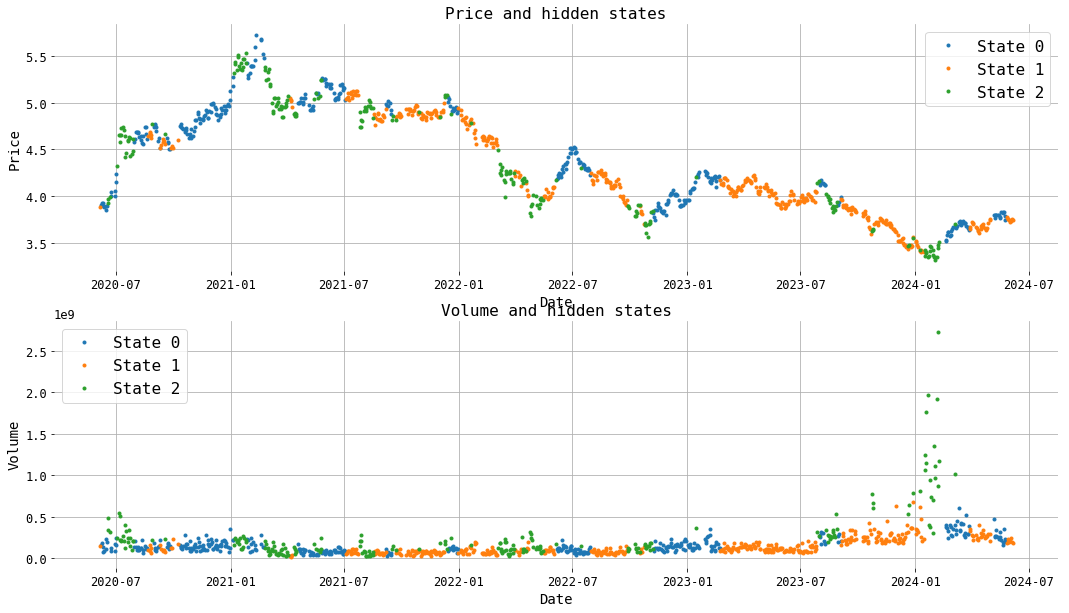

In [117]:
# 绘制价格曲线
plt.subplot(2, 1, 1)

for i in range(model.n_components):
    
    
    state_flag = (hidden_states == i)
    
    plt.plot(observation_pd.index[state_flag], observation_pd['price'][state_flag], '.', label=f'State {i}', lw=1.5)
    
plt.legend()
plt.title('Price and hidden states')
plt.xlabel('Date')
plt.ylabel('Price')


plt.subplot(2, 1, 2)


for i in range(model.n_components):
    
    
    state_flag = (hidden_states == i)
    
    plt.plot(observation_pd.index[state_flag], observation_pd['volume'][state_flag], '.', label=f'State {i}', lw=1.5)

    plt.legend()
plt.title('Volume and hidden states')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.show()